# Using Deep Learning to Predict Numerical Values using Antibody Thermostability as an Example


### Objectives:
    
- Use encoded antibody protein sequences to train models to predict experimental properties of proteins.

- Train a linear regression model to predict protein properties.

- Train a deep learning model to predict protein properties.

- Measuring success of regressive models and improving them.

### Introduction 

This notebook will cover fitting a machine learning predictor to a set of experimental values for a given set of proteins. These models can be very useful in quickly predicting these experimental values from the given sequence. The example which will be covered here is predicting the $\Delta$ G of Unfolding of antibodies from a given sequence. 

In order to train a model to predict the $\Delta$ G of Unfolding of antibodies, but firstly, the antibody sequences requires encoding using methods covered previously in this series. This data will then be used to train a regressive model.

Human antibody sequences taken from the Observed Antibody Space (n=8390; Olsen *et al.*, 2022) and each had thermostability calculated using the method developed by Oobatake (1993) to simulate an experimental dataset. This represents the antibody's thermostability as the $\Delta$ G of Unfolding where positive values represent a higher thermostability, and negative values represent a low thermostability where the protein is more likely to unfold spontaneously. By using a subset of these values for training, predicted thermostabilities can be obtained as the output and a test dataset can be used as a means to evaluate the error in the predictive model.

N.B. Antibodies and encoding methods were covered in previous notebooks in this series and so those should be covered to understand what is meant by antibody heavy and light chain pairing, as well as spacing antibody sequences according to numbering schemes.


### References


[Olsen, T. H., Boyles, F., & Deane, C. M. (2022). Observed Antibody Space: A diverse database of cleaned, annotated, and translated unpaired and paired antibody sequences. Protein Science, 31(1), 141–146.](https://doi.org/https://doi.org/10.1002/pro.4205)

[Oobatake, M., & Ooi, T. (1993). Hydration and heat stability effects on protein unfolding. Progress in Biophysics and Molecular Biology, 59(3), 237–284.](https://doi.org/10.1016/0079-6107(93)90002-2)

[Sequeira, A. M., Lousa, D., & Rocha, M. (2022). ProPythia: A Python package for protein classification based on machine and deep learning. Neurocomputing, 484, 172–182.](https://doi.org/https://doi.org/10.1016/j.neucom.2021.07.102)




## Imports and Requirements
The antibody encoding method we will be using is the Propythia program. Before starting we recommend installing it by copying and pasting the following command in your terminal/command line:

`pip install propythia`

The machine learning models that we will use are imported from the Keras package. We also suggest installing this via the following command: 

`pip install keras`

As this is a large package, rather than importing the whole package, it is better practise to just import the fuctions we require. As this usually leaves with a lot of import statements, we have broken them down what imports are required at what stage of the process.

In [15]:
##Import Get Encodings##
import numpy as np
import re
import warnings
from Bio import SeqIO
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import sys
from pandas import read_csv
sys.path.append('../src/')
sys.path.append('')

from numpy import mgrid, linspace, c_, arange, mean, array
from numpy.random import uniform, seed

##Imports for data preprocessing##
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression

##Imports for deep learning models###
##Import deep learning modules from Pytorch##
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedKFold


##Import modules for evaluating results and plotting##
from sklearn import metrics
from sklearn.metrics import make_scorer
from pandas import read_csv
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d
from matplotlib.pyplot import subplots, axes, scatter, xticks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error, r2_score


##Import for saving and loading model##
import pickle

In [16]:
def Get_dataset(fasta):
    ##Read all VH and VL sequences in the input FASTA file and encode them using Amino Acid Compositions##
    ###Propythia Command to get encodings###

    def get_descriptors(protein):
        # creating object to calculate descriptors
        # all except tripeptide and binaries representations, nlf and blosum encodings
        #test=protein.get_all(tricomp=False, bin_aa=False, bin_prop=False) 
        test= protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21])
        return(test)
    
    #Read sequences from FASTA file and save them as lists of VH and VL sequences##
    VH_sequences = []
    VL_sequences = []
    data = SeqIO.parse(fasta, "fasta")
    for i in data:
        if re.search("_VH",str(i.id)):
            VH_sequences.append(i.seq)
        elif re.search("_VL",str(i.id)):
            VL_sequences.append(i.seq)
            
   #Encode sequences using Physiochemical properties##
    if len(VH_sequences) == len(VL_sequences):
        VH_dataframe = pd.DataFrame()
        VL_dataframe = pd.DataFrame()
        for i in range(len(VH_sequences)):
            ps_string=sequence.read_protein_sequence(VH_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            VH_dataframe = VH_dataframe._append(descriptors, ignore_index=True)
        print("VH_data", VH_dataframe.shape)
        for i in range(len(VL_sequences)):
            ps_string=sequence.read_protein_sequence(VL_sequences[i])
            protein = Descriptor(ps_string)
            descriptors = get_descriptors(protein)
            VL_dataframe = VL_dataframe._append(descriptors, ignore_index=True)
        print("VL_data", VL_dataframe.shape)
    #Join the VH and VL dataframes together so that each sample now has information about its VH and VL sequence.
    VH_dataframe_suffix = VH_dataframe.add_suffix('_VH')
    VL_dataframe_suffix = VL_dataframe.add_suffix('_VL')
    joined_dataframe_VH_VL =  VH_dataframe_suffix.join(VL_dataframe_suffix)
    return(joined_dataframe_VH_VL)


## Generating the Encoded Dataset
Here we input our fasta file and split the entries into VH and VL sequences. We put each set of sequecnes through the Propythia encoder a dataframe of numerical information for both VH and VL sequences. 


In [17]:
### Input Fasta and Run Dataset###
input_fasta = './Delta_G_Fasta_Sequences.faa'
encodings = read_csv('./Delta_G_2000_Human_seq_encodings.csv', header=0)
Delta_G_Values = read_csv('./Delta_G_Values.csv', header = 0)
print(encodings.shape)

(8394, 891)


## Preparing the Data

When we have our encoded data, it is important to have  a train and test portion to monitor the performance of our model. Additionaly, shuffling the data is a method of eliminating any biases in the data which may be due to ordering in our dataset. We have incorporated shuffling into the train_test_split function.

In [18]:
##Split the data into training and testing sets##
dataset = encodings
dataset=dataset.loc[:, dataset.columns != 'Unnamed: 0']
 #Remove any indexes that could bias our data
y = Delta_G_Values
print(dataset.shape, y.shape)

#Get Train/Test Split#
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=0, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8394, 890) (8394, 1)
(5875, 890) (2519, 890) (5875, 1) (2519, 1)


## Build Linear Model

To test this hypothesis, we can quickly train a linear model to evaluate if this model can be trained before going through a lengthy deep learning model training.

Correlation coefficient: 0.9999273380972451


Text(0, 0.5, 'Observed delta G of Unfolding')

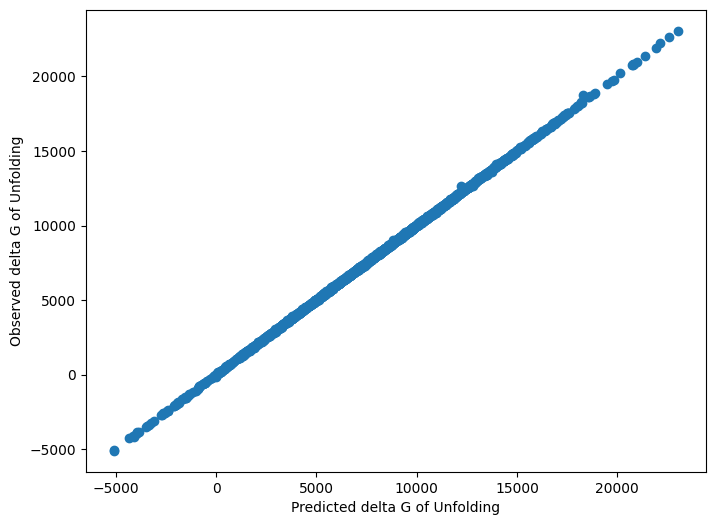

In [19]:
##Initialise linear model##
model = LinearRegression()
##Fit the model to the training data##
model.fit(X_train, y_train)
##Predict the delta G values of the test data##
y_pred = model.predict(X_test)

##Plot results of predicted values Vs observed values##
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(y_pred, y_test)
r2 = r2_score(y_test, np.array(y_pred))
print("Correlation coefficient:", r2)
ax.set_xlabel('Predicted delta G of Unfolding')
ax.set_ylabel('Observed delta G of Unfolding')



It looks from this initial test that the model is working very well, even when it's just a simple linear model. What would be interesting to test is if this is the result of the large sample size fed to the model, or whether there are key features encoded in the data that are being found by the model. This can be measured by the correlation coefficient of the predicted values and the observed experimental values. This should be as close to 1 as possible, as well as the mean squared error which should be as close to 0 as possible

(83, 890) (8311, 890) (83, 1) (8311, 1)
Correlation coefficient: 0.9586386238493678
Mean Squared Error: 721837.5618949804


Text(0, 0.5, 'Observed delta G of Unfolding')

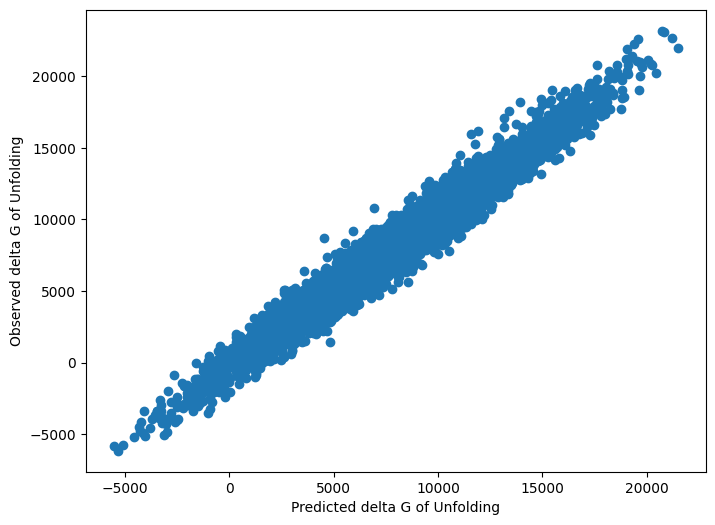

In [20]:
#Train and test split, using a train size of 1% to test the model##
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.99, random_state=0, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Plot results of predicted values Vs observed values##
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(y_pred, y_test)
r2 = r2_score(y_test, np.array(y_pred))
print("Correlation coefficient:", r2)
mse = mean_squared_error(y_test, np.array(y_pred))
print("Mean Squared Error:", mse)
ax.set_xlabel('Predicted delta G of Unfolding')
ax.set_ylabel('Observed delta G of Unfolding')



From this test where there was a significantly reduced training dataset, it seems that there is still a high correlation between predicted values and observed values, albeit less than the original. This suggests that there are highly correlated features in the encodings which the model is learning from.

In [21]:
# Get the model coefficients
coefficients = model.coef_

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({'Feature': list(X_train.columns), 'Importance': list(coefficients[0])})

# Calculate the absolute importance
feature_importances['Absolute Importance'] = feature_importances['Importance'].abs()

# Sort features by absolute importance
feature_importances = feature_importances.sort_values(by='Absolute Importance', ascending=False)

# Display the feature importances
print(feature_importances.head(10))

         Feature  Importance  Absolute Importance
451  formulaO_VL -319.700976           319.700976
488         Y_VL -270.389191           270.389191
483         F_VL  235.305270           235.305270
3    formulaC_VH  223.795209           223.795209
6    formulaO_VH -223.728273           223.728273
456    double_VL  207.556769           207.556769
448  formulaC_VL  206.379447           206.379447
11     double_VH  182.766299           182.766299
450  formulaN_VL -179.842063           179.842063
452  formulaS_VL  170.433499           170.433499


So it seems that there are highly correlated encodings, whether positively or negatively correlated, which can be informative to the model in its predictions. This might be the case for the amino acid encodings, however, would this work for the One Hot Encoding method? 

## Do it yourself

- Train a linear model using the same sequences, however, encode them using the One Hot Encoding method. Would you expect the same results? 
- Would the model require more data for such good performance? What does this performance tell you about how the model is learning and what data is best and what kind of encoding should be used for this task?


## Build Deep Learning Model
Another method, for more complex tasks, is to build a deep learning model. This will be similar to the model used in the previous notebook, but rather than binary classification, this model will be used for prediction of a continuous result, and so there will be some changes applied to reflect that. For instance, there is no sigmoid function at the last node and the loss function used here is the mean squared error loss function, which is more appropriate for regression tasks.

 

In [22]:
##Build models##

class Deep_Learning_Model(nn.Module):
    def __init__(self, input_size):
        super(Deep_Learning_Model, self).__init__()
        self.layer1 = nn.Linear(input_size, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 1)  # Output layer with a single neuron for regression

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.layer5(x)  # No activation function for the output layer
        return x
    

#Initialise model, criterion and optimizer#
learning_rate = 0.001
model = Deep_Learning_Model(X_train.shape[1])
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [23]:
#Convert data to Pytorch tensors#
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train_pt = torch.tensor(X_train.values, dtype=torch.float32)
X_test_pt = torch.tensor(X_test.values, dtype=torch.float32)
y_train_pt = torch.tensor(y_train.values,dtype=torch.float32).view(-1, 1)
y_test_pt = torch.tensor(y_test.values, dtype=torch.float32)

(83, 890) (8311, 890) (83, 1) (8311, 1)


Epoch [10/5000], Loss: 21757.1094
Epoch [20/5000], Loss: 27127.9160
Epoch [30/5000], Loss: 59968.5234
Epoch [40/5000], Loss: 208618.1719
Epoch [50/5000], Loss: 175002.7969
Epoch [60/5000], Loss: 101752.1719
Epoch [70/5000], Loss: 27872.0039
Epoch [80/5000], Loss: 19257.0762
Epoch [90/5000], Loss: 23183.7402
Epoch [100/5000], Loss: 2152634.5000
Epoch [110/5000], Loss: 4943215.0000
Epoch [120/5000], Loss: 922049.7500
Epoch [130/5000], Loss: 367128.5938
Epoch [140/5000], Loss: 321708.8125
Epoch [150/5000], Loss: 114580.1719
Epoch [160/5000], Loss: 59830.6758
Epoch [170/5000], Loss: 53711.5859
Epoch [180/5000], Loss: 28003.8457
Epoch [190/5000], Loss: 25863.7461
Epoch [200/5000], Loss: 23738.1934
Epoch [210/5000], Loss: 21968.7988
Epoch [220/5000], Loss: 21009.6484
Epoch [230/5000], Loss: 20258.6309
Epoch [240/5000], Loss: 19626.5430
Epoch [250/5000], Loss: 19115.4648
Epoch [260/5000], Loss: 18741.3418
Epoch [270/5000], Loss: 20530.1621
Epoch [280/5000], Loss: 29478.6055
Epoch [290/5000], 

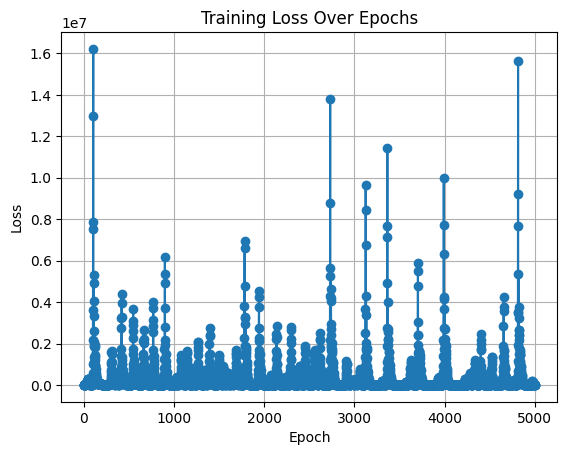

In [28]:
#Train deep learning model over a set number of epochs#
epochs = 5000
loss_values = []

for epoch in range(epochs):
    model.train()
    
    #Calculate loss function#
    outputs = model(X_train_pt)
    loss = loss_function(outputs, y_train_pt)
    loss_values.append(loss.item())

    #Update weights#
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print the loss every 10 epochs#
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

#Save final state model#
torch.save(model.state_dict(), 'Thermostability_model.pkl')

#Plot Loss Function Over Epochs#
plt.plot(range(1, epochs+1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


With our model trained and tested. Now we can use it to predcit the $\Delta$ G values of the testing portion of our dataset. These results can then be stored in an array and plotted against their actual values as a measure of the success of our predictor. Upon plotting the results, we would expect to see a linear relationship between the observed and expected results with a high correlation coefficient.

Correlation coefficient: 0.7059547184241265
Mean Squared Error: 8767809.179916622


Text(0, 0.5, 'Observed delta G of Unfolding')

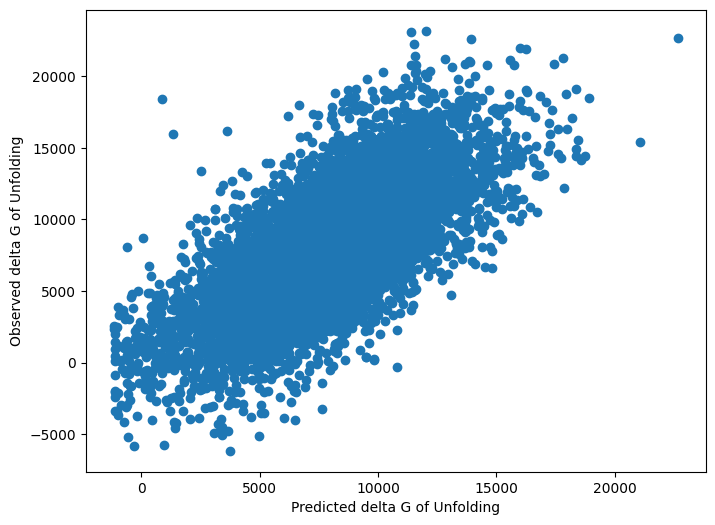

In [29]:
#Use model to predict test data values#
model.eval()
with torch.no_grad():
    predictions = model(X_test_pt)
    predictions = predictions.numpy()
    
#Get Correlation coefficient of predicted values Vs observed values##
correlation_coefficient = np.corrcoef(list(predictions.flatten()),list(y_test['Delta G of Unfolding'].values) )
print("Correlation coefficient:", correlation_coefficient[0][1])
mse = mean_squared_error(list(predictions.flatten()),list(y_test['Delta G of Unfolding'].values))
print("Mean Squared Error:", mse)
#Plot results of predicted values Vs observed values##
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(predictions, y_test)
ax.set_xlabel('Predicted delta G of Unfolding')
ax.set_ylabel('Observed delta G of Unfolding')

Do it yourself

- The default settings used in the previous exercise seem to not perform well for this kind of data. Perhaps then some additional changes need to be made. Try out some changes to the parameter to try and improve performance

- If it continues not to work, maybe ask if the data used is suitable for this task, or if the model is not learning from these features?


## Testing on a Naive Dataset
Now we can try out our model on a totally naive dataset by encoding our data in the same way as our input dataset. This will be a good measure of model performance and poor performance of the model here could be a sign overfitting to the training data.

In [39]:
### Input Fasta and Run Dataset###
Naive_fasta = './all_test.faa.txt'
naive_encodings = Get_dataset(Naive_fasta)

naive_observed_results = "all_test.faa.txt_Delta_G.txt"

NameError: name 'sequence' is not defined

In [40]:
###Load saved model###

loaded_model = model
###Predict thermostability with loaded model###
with torch.no_grad():
    predictions = model(X_test_pt)
    predictions = predictions.numpy()
    naive_prediction = loaded_model.predict(naive_encodings)
    Naive_observed_results = read_csv(naive_observed_results,header=0).to_numpy()


#Plot results of predicted values Vs observed values##
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(naive_prediction, Naive_observed_results)
correlation_coefficient = np.corrcoef(predictions,y_test['Delta G of Unfolding'].values)
print("Correlation coefficient:", correlation_coefficient[0][1])
ax.set_xlabel('Predicted delta G of Unfolding')
ax.set_ylabel('Observed delta G of Unfolding')

AttributeError: 'Deep_Learning_Model' object has no attribute 'predict'

## End of Chapter Exercises


There are many more properties of antibodies, or any protein that we could train an ANN to predict. For instance, we can use isoelectrisity as another example. Isoelectrisity (pI) is the pH which a protein requires to have a net charge of zero. Usually this is around 6-7, but more charged proteins may have either higher or lower values of pI. In the material for this worksheet, another file containing the pI values for all of the antibodies used in this workbook. Generate a new ANN predictor to demonstrate that this property may be calculated from our encoded antibodies too.

- Demonstrate the linear relationship between predicted and observed results.

## Summary

This workbook should have demonstrated the ability of machine learning models to be trained on to predict experimental values from an encoded amino acid. This can be done using linear and deep learning models, however, it has been shown that using appropriate method of encodings is key to the success of these models.

## Key points

From the exercise above you should have learned
- How to predict a numerical result using linear regression and a regressive deep learning model
- How to evaluate the performance of a regressive model
- How regressive models can be trained to calculate the features of proteins using experimental data and protein encodings
- Deep learning models are not always the most suitable models if a linear model already has a good predictive ability